# **SVM (Support Vector Machines)**

In this notebook, we will use Support Vector Machines (SVM) to build and train a model using human cell records, and classify cells as lto whether it is benign or malignant.

SVM works by using the concept of a large margin classifier. It maps the data in a high-dimensional feature space so that data points can be categorised, even when the data is not linearly separable. A separator between the categories is found, and the data is transformed in such a way that the separator could be drawn as a hyperplane. Afterwards, the characteristics of new data can be used to predict the group to which a new record should belong. 

References:


1.   IBM Cousera Machine Learning Course



## **Importing the Required Libraries**

In [0]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

## **Loading the Cancer Data**

The example is based on a dataset that is publicly available from UCI Machine Learning Repository (Asuncion and Newman, 2007) [http://mlearn.ics.uci.edu/MLRepository.html]. The dataset consists of several hundred human cell sample data, each which contains the values of a set of cell characteristics. The field in each record are:

<table>
  <tr>
    <th> Field Name </th>
    <th> Description </th>
  </tr>
  <tr>
    <td> ID </td>
    <td> Clump Thickness </td>
  </tr>
  <tr>
    <td> Clump </td>
    <td> Clump Thickness </td>
  </tr>
  <tr> 
    <td> UnifSize </td>
    <td> Uniformity of Cell Size </td>
  </tr>
  <tr>
    <td> UnifShape </td>
    <td> Uniformity of Cell Shape </td>
  </tr>
  <tr> 
    <td> MargAdh </td>
    <td> Marginal Adhesion </td>
  </tr>
  <tr> 
    <td> SingEpiSize</td>
    <td> Single Epithelial Cell Size </td>
  </tr>
  <tr>
    <td> BareNuc </td>
    <td> Bare Nuclei </td>
  </tr> 
  <tr> 
    <td> BlandChrom </td>
    <td> Bland Chromatin </td>
  </tr>
  <tr> 
    <td> NormNucl </td>
    <td> Normal Nucleoli </td>
  </tr>
  <tr> 
    <td> Mit </td>
    <td> Mitosis </td>
  </tr>
  <tr>
    <td> Class </td>
    <td> Benign or malignant </td>
  </table>

For this sample, we are using a dataset that has relatively small number of predictors. We will first need to download the data from the IBM Object Storage.

In [0]:
#Click here and press Shift+Enter
!wget -O cell_samples.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cell_samples.csv

--2019-02-03 09:56:59--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cell_samples.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20675 (20K) [text/csv]
Saving to: ‘cell_samples.csv’

cell_samples.csv    100%[===================>]  20.19K  --.-KB/s    in 0.01s   

2019-02-03 09:56:59 (1.60 MB/s) - ‘cell_samples.csv’ saved [20675/20675]



### **Load Data From CSV File**

In [0]:
cell_df= pd.read_csv ("cell_samples.csv")
cell_df.head()


,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


The ID field contains the patient identifiers. The characteristics of the cell samples from each patient are contained in fields Clump to Mit. The values are graded from 1 to 10, with 1 being the closest to benign.

The class field contains the diagnosis, as to whether the samples are benign (value=2) or malignant (value=4). 

Let's look at the distribution of classes based on Clump Thickness and Uniformity of Cell Size.

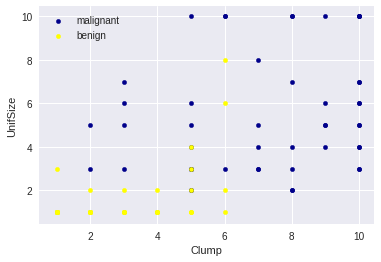

In [0]:
ax = cell_df[cell_df['Class'] == 4][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='DarkBlue', label='malignant');
cell_df[cell_df['Class'] == 2][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='Yellow', label='benign', ax=ax);
plt.show()

## **Data pre-processing and Selection**

Let's first look at columns data types. 

In [0]:
cell_df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

It looks like **BareNuc** column contains some values which are not numerical. Let's drop those rows.

In [0]:
#conversion of argument into numeric type
# for errors "coerce", invalid parsing will be set as NaN 
# pandas.notnull() detects non-missing values for array-like object
cell_df = cell_df[pd.to_numeric(cell_df['BareNuc'], errors='coerce').notnull()]
cell_df['BareNuc'] = cell_df['BareNuc'].astype('int')
cell_df.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int64
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [0]:
feature_df = cell_df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
# np.asarray: convert input data into array 
X = np.asarray(feature_df)


We want the model to predict the value of Class (that is, benign (=2) or malignant (=4)). As this field can have one of only two possible values, we need to change its measurement level to reflect this.

In [0]:
cell_df['Class'] = cell_df['Class'].astype('int')
# np.asarray: convert input data into array 
y = np.asarray(cell_df['Class'])


## **Train/ Test Dataset**

Firstly, we will split our dataset into training and test set. We split into 70% training set and 30% test set.  

In [0]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

scaler=preprocessing.StandardScaler()
X_train_=scaler.fit_transform(X_train)
X_test_=scaler.transform(X_test)

Train set: (478, 9) (478,)
Test set: (205, 9) (205,)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## **Modelling (SVM with Scikit-learn)**

Kernelling is when we map data into higher dimensional space. There aren different kernel functions that can be used, such as 

1.   Linear
2.   Polynomial
3.   Radial bias function (RBF)
4.   Sigmoid 

There is no easy way of knowing which function works best. Most of the time, we choose different functions and compare the results. Let's use the default (Radial Bias Function) for this. 





In [0]:
from sklearn import svm
#SVC: an implementation of Support Vector Machine
clf = svm.SVC(kernel='rbf')
clf.fit(X_train_, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

After the model is fitted, it  can be used to predict new values. 

In [0]:
yhat = clf.predict(X_test_)

## **Evaluation of Model**

For the evaluation of our model, let's try the jaccard index for accuracy. The closer the index is to 1, the more accurate is the model in the predictions. 

In [0]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

0.9365853658536586